In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
from utils import load_img, resize_crop, imshow, interleave
%matplotlib inline

# Global params

In [2]:
img_directory = '/Users/rwilliams/Desktop/celeba/training'
img_save_directory = '/Users/rwilliams/Desktop/celeba/out'
# save / load model here
model_weights_path = '/Users/rwilliams/Desktop/celeba/celeba-vaegan-weights.hdf5'
batch_size = 64
# training_set_size = 4992
training_set_size = 128
img_size = 64

# Load training data

In [3]:
training = np.array([resize_crop(load_img(i+1, img_directory), (img_size, img_size)) for i in range(training_set_size)])

/Users/rwilliams/anaconda/envs/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# Create model and load weights

Instantiate model

In [4]:
from autoencoder import Autoencoder
from discriminator import Discriminator
from keras.optimizers import Adam

vae = Autoencoder(img_shape=(img_size, img_size, 3), batch_size=batch_size)
vae.build_model()

disc = Discriminator(img_shape=(img_size, img_size, 3), batch_size=batch_size)
disc.build_model()

Using TensorFlow backend.


(None, 64, 64, 3)
(None, 30, 30, 32)
(None, 13, 13, 128)
(None, 5, 5, 256)
(None, 1, 1, 256)
(None, 256)


In [5]:
optimizer = Adam(lr=.00001)

In [6]:
# disc.model.predict(training[:batch_size], batch_size=batch_size).shape

In [7]:
# model.model.compile(Adam(lr=.00001), 'binary_crossentropy')
# model.model.compile(Adam(lr=.000001), 'binary_crossentropy')

# Train

Given real image training data, constructs a training set for the discriminator consisting of the real images, autoencoder coded then decoded images, and images generated by decoding a sample fro z. Returns tuple (training, labels).

In [8]:
def generate_disc_training_data(images, vae, batch_size, img_rows, img_cols, channels=3):
    data_set_size = images.shape[0]
    # real images encoded, then decoded
    encdec = vae.model.predict(images, batch_size=batch_size)
    # sampled from z then decoded. Do for as many as number of images.
    sampled = vae.decoder.predict(np.random.normal(size=(data_set_size, vae.zsize)), batch_size=batch_size)
        
    training = interleave(images, encdec, sampled)
    # 0 for real, 1 for fake
    labels = interleave(np.zeros(data_set_size), np.ones(data_set_size), np.ones(data_set_size))
    return (training, labels)

In [9]:
disc_training, disc_labels = generate_disc_training_data(training, vae, batch_size, img_size, img_size)

disc.model.compile(optimizer, 'binary_crossentropy')
disc.model.fit(disc_training, disc_labels, epochs=1, batch_size=batch_size, verbose=True)

Epoch 1/1
384/384 [==============================] - 2s - loss: 0.2763     


In [10]:
vae.mode('train_encoder')
vae.model.compile(optimizer, disc.diff_loss)
vae.model.fit(training, training, epochs=1, batch_size=batch_size, verbose=True)

ValueError: The shape of the input to "Flatten" is not fully defined (got (None, None, 256). Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.

Reset image save filename counter

save_idx = 0

Define some useful Keras callbacks

In [ ]:
# save an image of prediction before training
# predictions = model.model.predict(training[:batch_size], batch_size=batch_size)
# path = os.path.join(img_save_directory, '%04d.jpg' % save_idx)
# sp.misc.imsave(path, predictions[0])
# save_idx += 1

start = save_idx
stop = save_idx + 9999

for i in range(start, stop):
    model.model.fit(x=training, y=training, epochs=1, batch_size=batch_size, verbose=True)
    predictions = model.model.predict(training[:batch_size], batch_size=batch_size)
    path = os.path.join(img_save_directory, '%04d.jpg' % i)
    sp.misc.imsave(path, predictions[0])
    model.model.save_weights(model_weights_path)
    save_idx = i

In [17]:
from keras import backend as K
K.eval(model.model.optimizer.lr)

9.9999997e-06

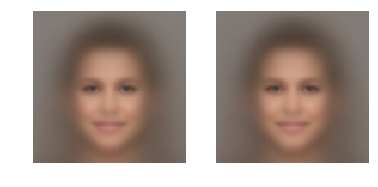

In [57]:
predictions = model.model.predict(training[:batch_size], batch_size=batch_size)
imshow([predictions[0], predictions[7]])